# PROBLEMA 2
Una empresa dedicada a la distribución de agua potable ha recabado datos históricos relacionada con la cantidad de sulfatos y nitratos presentes en el agua. Dicha empresa tiene la suposición de que la cantidad de sulfatos en el agua está fuertemente correlacionada con la cantidad de nitratos presentes en la misma, tal que a mayor cantidad de los primeros, mayor cantidad de los segundos.

Los datos históricos relacionados con el análisis de estos componentes en el agua se presenta en la carpeta comprimida adjunta (distributed-data.zip). Nótese que en los datos existen instancias en las cuales no hay registro de las cantidades de sulfatos/nitratos, las cuales se asumen se derivan de fallas en los instrumentos utilizado para hacer estas mediciones.

**Analice dichos datos y realice las siguientes tareas:**
- a. Construir un único dataset utilizando toda la información histórica proporcionada por la empresa.
- b. Generar un histograma que presente el número de mediciones "utiles" VS las mediciones erroneas presentadas por los instrumentos de medición e indique: ¿Qué tan grande es la proporción de mediciones erróneas en comparación a las mediciones útiles del instrumento?
- c. Construir un modelo de regresión lineal en el que se establezca la relación entre las variables sulfato/nitratos utilizando el dataset generado. Indique los parámetros de dicho modelo.
- d. Indicar si la correlación entre la cantidad de sulfatos/nitratos es tal como la plantea la empresa. Justificar su respuesta.

## Librerias

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## a) Construir dataset

Dado que nuestros datos se encuentran en multiples archivos CSV, lo primero que haremos sera leer todos los archivos que se encuentren en la carpeta "distributed-data", por precaucuión, ignoraremos cualquier archivo que no tenga la extensión .csv. Posteriormente, concatenaremos todos los datos en un solo DataFrame de pandas usando la función pd.concat().

In [2]:
data_dir = 'data/distributed-data'
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith('.csv')]
df2 = pd.DataFrame()
for file in csv_files:
    df_temp = pd.read_csv(os.path.join(data_dir, file))
    df2 = pd.concat([df2, df_temp], ignore_index=True)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772087 entries, 0 to 772086
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Date     772087 non-null  object 
 1   sulfate  118783 non-null  float64
 2   nitrate  114349 non-null  float64
 3   ID       772087 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 23.6+ MB


## b) Mediciones útiles vs erróneas

Dado que las columnas de Fecha e ID no son relevantes para nuestro análisis, ignoraremos dichas columnas y nos quedaremos unicamente con las columnas de Sulfatos y Nitratos.
Ademas de esto, vamos a necesitar 4 dataframes diferentes:
- df_total: Contiene todos los datos originales extraidos de los archivos CSV.
- df_erroneas: Contiene unicamente registros de las mediciones con al menos 1 valor faltante.
- df_incompletos: Contiene unicamente las filas que tengan a lo mucho un dato faltante en alguna de las dos columnas (sulfato o nitrato).
- df_completos: Contiene unicamente las filas que tengan ambos datos (sulfato y nitrato) completos.

In [3]:
df_total = df2[['sulfate', 'nitrate']]
df_erroneas = df_total[df_total.isnull().any(axis=1)]
df_incompletos = df_total[df_total.isnull().sum(axis=1) <= 1]
df_completos = df_total.dropna()

print("Total de filas en df_total:", len(df_total))
print("Total de filas en df_erroneas:", len(df_erroneas))
print("Total de filas en df_incompletos:", len(df_incompletos))
print("Total de filas en df_completos:", len(df_completos))

Total de filas en df_total: 772087
Total de filas en df_erroneas: 660285
Total de filas en df_incompletos: 121330
Total de filas en df_completos: 111802


Generaremos unas graficas de barras para poder observar el numero de mediciones que tiene el dataset en cada una de sus versiones.

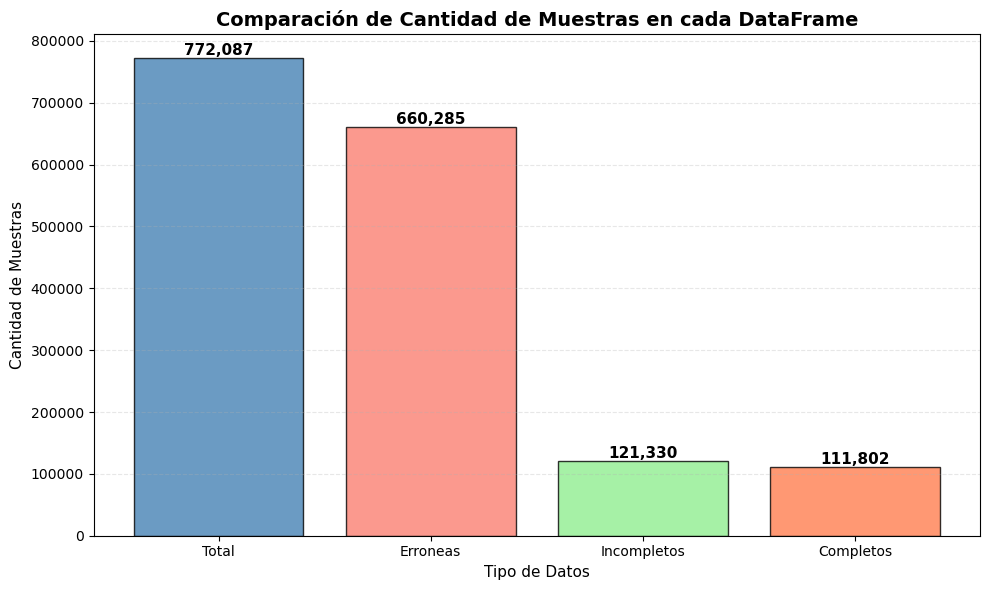

In [4]:
cantidad_muestras = [len(df_total), len(df_erroneas), len(df_incompletos), len(df_completos)]
nombres_dataframes = ['Total', 'Erroneas', 'Incompletos', 'Completos']

plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_dataframes, cantidad_muestras, color=['steelblue', 'salmon', 'lightgreen', 'coral'], 
               edgecolor='black', alpha=0.8)

# Agregar valores en cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Tipo de Datos', fontsize=11)
plt.ylabel('Cantidad de Muestras', fontsize=11)
plt.title('Comparación de Cantidad de Muestras en cada DataFrame', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [5]:
111802*100/772087

14.480492483360036

Como se puede apreciar, originalmente el dataframe cuenta con 772087 registros de las mediciones historicas, pero solamente 111802 (14.48%) de ellas pueden considerarse como mediciones útiles, es decir, aquellas que tienen tanto el valor de sulfatos como el de nitratos completos.

Lo que sigue es hacer un histograma para observar la distribución de los valores de sulfatos y nitratos en las mediciones útiles (completas). Para esto, reutilizaremos la función de get_n_bins que se usó en el problema 1.

In [6]:
def get_n_bins(data):
    # Calcula el número óptimo de bins para un histograma usando la regla de Sturges.
    M = len(data)
    c = int(np.ceil(1+np.log2(M)))
    return c

Generamos nuestros histogramas para los valores de sulfatos y nitratos en las mediciones completas.

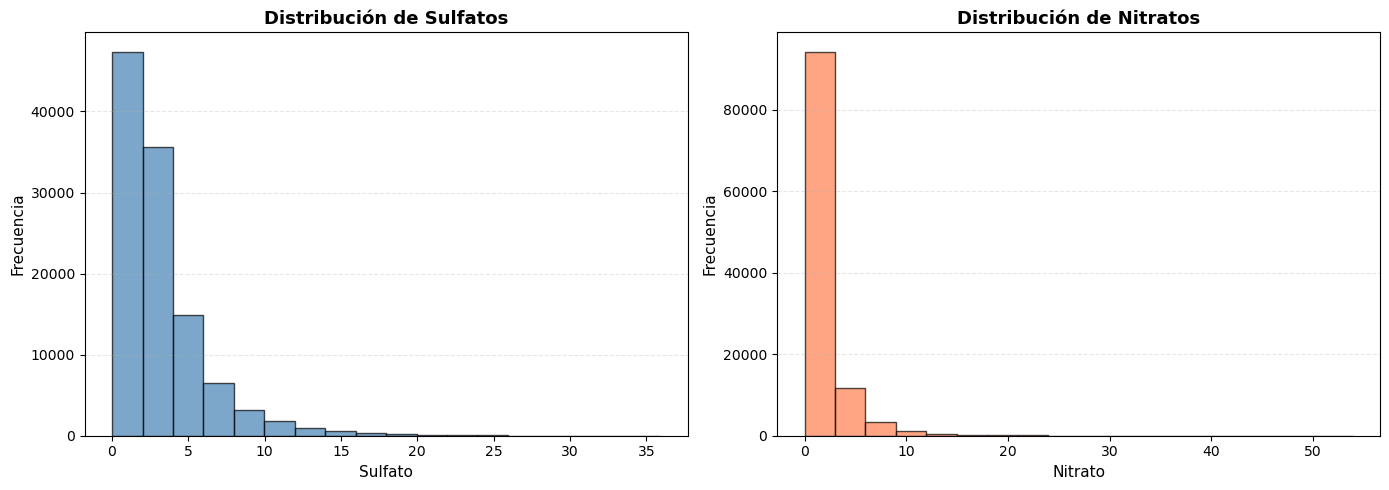

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n_bins_sulfatos = get_n_bins(df_completos['sulfate'])
axes[0].hist(df_completos['sulfate'], bins=n_bins_sulfatos, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sulfato', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de Sulfatos', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

n_bins_nitratos = get_n_bins(df_completos['nitrate'])
axes[1].hist(df_completos['nitrate'], bins=n_bins_nitratos, color='coral', 
             edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Nitrato', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Nitratos', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


A simple vista podemos observar que ambos histogramas tienen una distribución similar, con un pico pronunciado en valores bajos (cerca de 0) y una disminución gradual a medida que los valores aumentan. Para la hipotesis planteada de que a mayor cantidad de sulfatos, mayor cantidad de nitratos, podemos observar que en ambos histogramas, la mayoría de las mediciones se concentran en valores bajos, lo que sugiere una posible correlación positiva entre ambas variables, pero estas graficas pueden ser engañosas, ya que las escalas de ambos histogramas son diferentes, por lo que no podemos concluir nada con certeza a partir de estas graficas.

## c) Modelo de regresión lineal

Antes que nada, dividiremos nuestro dataframe de mediciones completas (df_completos) en un conjunto de entrenamiento y un conjunto de prueba. Utilizaremos el 70% de los datos para entrenar el modelo y el 30% restante para evaluar su desempeño.

Para el modelo de regresión lineal, utilizaremos la librería scikit-learn. Primero, definiremos cual sera X o la entrada de nuestro modelo, y cual sera Y o la etique de nuestro modelo. En este caso, X sera la columna de sulfatos y Y sera la columna de nitratos del dataframe de mediciones completas (df_completos).

Ya con los datos preparados, podemos proceder a entrenar el modelo de regresión lineal utilizando el conjunto de entrenamiento.


In [8]:
df_train, df_test = train_test_split(df_completos, test_size=0.3)

lm = LinearRegression()
lm.fit(df_train[['sulfate']], df_train['nitrate'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Para evaluar el desempeño del modelo, hicimos una pequeña funcion llamada val_model que recibe como parámetros el modelo entrenado, las entradas (X) y las etiquetas (Y) del conjunto de datos a evaluar. La función utiliza el modelo para hacer predicciones sobre las entradas proporcionadas y luego calcula un par de metricas (RSE) para ver cual fue la bondad de ajuste de nuestro modelo. Finalmente, retorna un vector de predicciones realizadas por el modelo para su posterior análisis.

In [9]:
def val_model(model: LinearRegression, x, y):
    preds = model.predict(x)
    SSD = np.sum((y-preds)**2)
    RSE = np.sqrt(SSD/(len(x)-1))
    # Calcular RSE_%
    y_mean = np.mean(y)
    RSE_rate = RSE/y_mean
    print("Score = ",model.score(x,y))
    print("SSD = ",SSD)
    print("RSE = ",RSE)
    print("RSE_% = ",RSE_rate)
    return preds

Validamos el modelo con nuestro conjunto de entrenamiento y nuestro conjunto de prueba para ver cómo se desempeña en ambos casos.

In [10]:
print("Datos de Entrenamiento:")
pred_train = val_model(lm, df_train[['sulfate']], df_train['nitrate'])
print("\nDatos de Prueba:")
pred_test = val_model(lm, df_test[['sulfate']], df_test['nitrate'])

Datos de Entrenamiento:
Score =  0.0036335622506815657
SSD =  500656.3424110264
RSE =  2.5292976432186958
RSE_% =  1.4799682836147412

Datos de Prueba:
Score =  0.0045235204159411735
SSD =  206063.39866087824
RSE =  2.478671082605502
RSE_% =  1.4543059082493832


Como se puede observar, el modelo tiene una bondad de ajuste muy baja tanto en los datos de entrenamiento como en los datos de prueba, con un score muy cercano a 0 y un porcentaje de error (RSE) muy alto. Esto indica que el modelo no es capaz de encontrar un ajuste lineal adecuado entre las variables de sulfatos y nitratos en los datos proporcionados.

## D) Correlación entre sulfatos y nitratos

Si imprimimos los puntos en una grafica haciendo relacion del valor de nitratos con sulfatos, podemos observar que los puntos estan muy dispersos y no siguen una tendencia lineal clara, ademas de que si agregamos la linea de regresion obtenida por el modelo, podemos ver que esta no se ajusta totalmente a los datos.

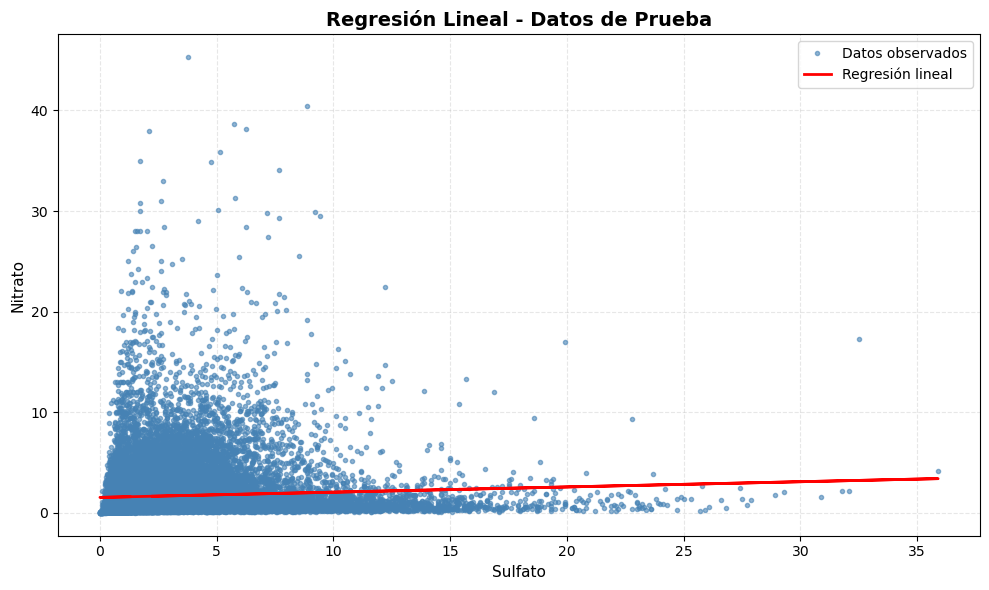

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['sulfate'], df_test['nitrate'], "o", color='steelblue', markersize=3, alpha=0.6, label='Datos observados')
plt.plot(df_test['sulfate'], pred_test, color='red', linewidth=2, label='Regresión lineal')
plt.title("Regresión Lineal - Datos de Prueba", fontsize=14, fontweight='bold')
plt.xlabel('Sulfato', fontsize=11)
plt.ylabel('Nitrato', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

La libreria de pandas nos permite calcular correlaciones entre columnas de un DataFrame de manera sencilla utilizando el método .corr(), e incluso nos permite especificar el método de correlación que queremos utilizar (Pearson, Spearman, Kendall, etc.). En este caso, utilizaremos el método de Pearson para calcular la correlación entre las columnas de sulfatos y nitratos en nuestro DataFrame de mediciones completas (df_completos).

In [12]:
print("Matriz de Correlación:")
print(df_completos.corr())

correlacion = df_completos['sulfate'].corr(df_completos['nitrate'], method='pearson')
print(f"\nCorrelación de Pearson: {correlacion:.4f}")

Matriz de Correlación:
          sulfate   nitrate
sulfate  1.000000  0.062434
nitrate  0.062434  1.000000

Correlación de Pearson: 0.0624


Por lo tanto, podemos concluir que la hipótesis planteada por la empresa no se sostiene con los datos proporcionados, ya que la correlación entre las cantidades de sulfatos y nitratos es muy baja (0.0624), lo que indica que no existe una relación lineal significativa entre ambas variables en el conjunto de datos analizado.